In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'
base_path='/data/'

In [133]:
circuits = pd.read_csv(base_path+'circuits.csv')
constructorresults = pd.read_csv(base_path+'constructor_results.csv')
constructorstandings = pd.read_csv(base_path+'constructor_standings.csv')
constructors = pd.read_csv(base_path+'constructors.csv')
driverstandings = pd.read_csv(base_path+'driver_standings.csv')
drivers = pd.read_csv(base_path+'drivers.csv')
laptimes = pd.read_csv(base_path+'lap_times.csv')
pitstops = pd.read_csv(base_path+'pit_stops.csv')
qualifying = pd.read_csv(base_path+'qualifying.csv')
races = pd.read_csv(base_path+'races.csv')
results = pd.read_csv(base_path+'results.csv')
seasons = pd.read_csv(base_path+'seasons.csv')
status = pd.read_csv(base_path+'status.csv')

In [134]:
dataset= results.merge(races,how="inner",on="raceId",suffixes=[None,'_race'])\
                .merge(drivers,how="inner",on="driverId",suffixes=[None,'_driver'])\
                .merge(constructors,how="inner",on="constructorId",suffixes=[None,'_constructor'])\
                .merge(circuits,how="inner",on="circuitId",suffixes=[None,'_circuit'])\
                .merge(status,how="inner",on="statusId",suffixes=[None,'_status'])\
                .merge(driverstandings,how="inner",on=['raceId','driverId'],suffixes=[None,'_standings'])

columns_to_drop=['time','milliseconds','number','resultId','positionText','fastestLap', 'rank', 'fastestLapTime',
                 'fastestLapSpeed','statusId','circuitId','url','url_driver','url_constructor','lat', 'lng', 'alt',
                 'url_circuit','driverStandingsId','positionText_standings','wins']
dataset = dataset.drop(columns_to_drop,axis="columns")

In [135]:
dataset.columns

Index(['raceId', 'driverId', 'constructorId', 'grid', 'position',
       'positionOrder', 'points', 'laps', 'year', 'round', 'name', 'date',
       'time_race', 'driverRef', 'number_driver', 'code', 'forename',
       'surname', 'dob', 'nationality', 'constructorRef', 'name_constructor',
       'nationality_constructor', 'circuitRef', 'name_circuit', 'location',
       'country', 'status', 'points_standings', 'position_standings'],
      dtype='object')

In [136]:
dataset = dataset[dataset.year >= 2010]

In [137]:
dataset['fullname'] = dataset['forename']+' '+dataset['surname']
drivers_2020 = ['Daniel Ricciardo', 'Kevin Magnussen', 'Carlos Sainz',
'Valtteri Bottas', 'Lance Stroll', 'George Russell','Lando Norris', 'Sebastian Vettel', 'Kimi Räikkönen',
'Charles Leclerc', 'Lewis Hamilton', 'Daniil Kvyat','Max Verstappen', 'Pierre Gasly', 'Alexander Albon',
'Sergio Pérez', 'Esteban Ocon', 'Antonio Giovinazzi','Romain Grosjean','Nicholas Latifi']
dataset['drivers_2020'] = dataset['fullname'].apply(lambda x: int(x in drivers_2020))

In [138]:
# on garde que ceux dont on a besoin
dataset = dataset[dataset.drivers_2020 == 1]

In [139]:
# target 
def position_categorizer(position):
    if position > 0 and position <= 3:
        return 1
    elif position > 3 and position <= 10:
        return 2
    else:
        return 3

dataset['podium'] = dataset['positionOrder'].apply(lambda x: 1 if (x > 0) and (x <= 3) else 0)
dataset['top10']  = dataset['positionOrder'].apply(lambda x: 1 if (x > 0) and (x <= 10) else 0)
dataset['pod_10_else']  = dataset['positionOrder'].apply(lambda x: position_categorizer(x))

<AxesSubplot:>

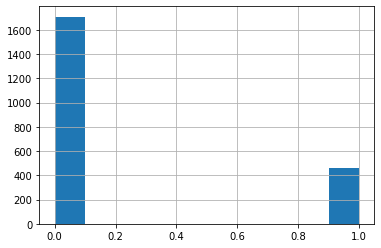

In [140]:
dataset['podium'].hist()

In [141]:
# renaming driverRef column to make the standard driver column 
dataset=dataset.rename(columns={"driverRef":"driver"})

# same thing as above for constructor 
dataset=dataset.rename(columns={"constructorRef":"constructor"})

#dataset=dataset.drop(['laps','time_race','name_constructor','dob','number_driver','code'],axis=1)

In [142]:
# editing nationality and circuit country to a matching format
country_dict = {'UK' : 'Bri','USA':'Ame','France':'Fre'}
dataset['country'] = dataset['country'].apply(lambda x: str(x)[:3] if x not in ['UK','USA'] else country_dict[str(x)])
dataset['nationality'] = dataset['nationality'].apply(lambda x: str(x)[:3])
dataset['nationality_constructor'] = dataset['nationality_constructor'].apply(lambda x: str(x)[:3])

<AxesSubplot:>

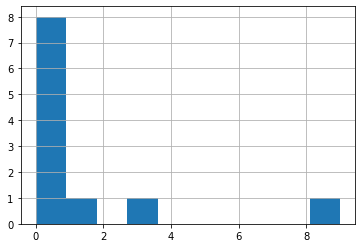

In [143]:
# distribution des podium des race effectuer a domicile
dataset[dataset.country == dataset.nationality].groupby('driver',as_index=False)['podium'].sum()['podium'].hist()

<AxesSubplot:>

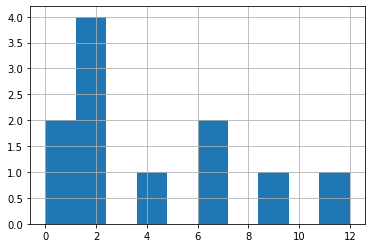

In [144]:
# distribution des top10 des race effectuer a domicile
dataset[dataset.country == dataset.nationality].groupby('driver',as_index=False)['top10'].sum()['top10'].hist()

In [145]:
# remplacement de dob by age 
today = pd.Timestamp.today()
dataset['date']= pd.to_datetime(dataset['date'])
dataset['dob'] = pd.to_datetime(dataset['dob'])
dataset['age'] = dataset[['date','dob']].apply(lambda x: x[0].year-x[1].year,axis=1)

<AxesSubplot:>

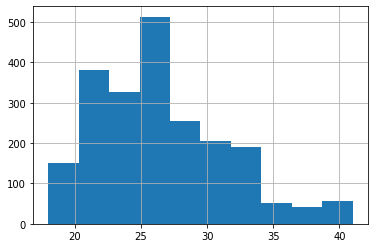

In [146]:
dataset.age.hist()

<AxesSubplot:>

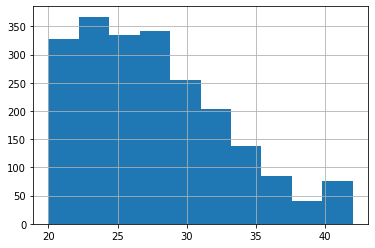

In [478]:
dataset['age2'] = dataset['age'].apply(lambda age: int((age/2)+1) * 2)
dataset['age2'].hist()

<AxesSubplot:xlabel='age2'>

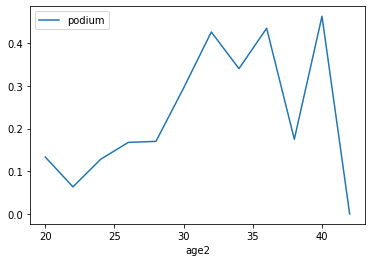

In [481]:
# influence de l'age sur les resultat 
dataset.groupby('age2',as_index=False)['podium'].mean().plot.line(x='age2',y='podium')

In [178]:
dataset[dataset.age >= 37]['driver'].unique()

array(['raikkonen'], dtype=object)

In [ ]:
dataset.groupby(['name'],as_index=False)['date'].size()

<AxesSubplot:xlabel='name'>

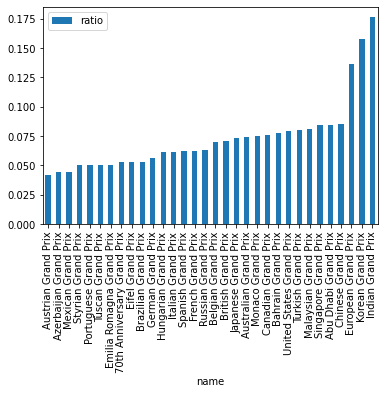

In [197]:
# gp max podium by one driver
gp_max_win_by_one = dataset.groupby(['name','driver'],as_index=False)['podium'].sum()\
        .groupby('name',as_index=False)['podium'].max()
gp_organized_count = dataset.groupby(['name'],as_index=False)['date'].size()

to_plot = gp_max_win_by_one.merge(gp_organized_count,how="inner",on='name')
to_plot['ratio'] = to_plot['podium'] / to_plot['size']

to_plot.sort_values(by='ratio').plot.bar(x='name',y='ratio')



In [154]:
def gp_driver_win_ratio(gp,driver):
    driver_gp_data = dataset[(dataset.name == gp) 
                             & (dataset.driver == driver)]
    podium = driver_gp_data['podium'].sum()
    participated = driver_gp_data['podium'].count()
    return podium/participated

In [155]:
dataset['gp_driver_win_ratio'] = dataset[['name','driver']].apply(lambda x: gp_driver_win_ratio(x[0],x[1]),axis=1).fillna(0)
dataset.head()

,raceId,driverId,constructorId,grid,position,positionOrder,points,laps,year,round,name,date,time_race,driver,number_driver,code,forename,surname,dob,nationality,constructor,name_constructor,nationality_constructor,circuitRef,name_circuit,location,country,status,points_standings,position_standings,fullname,drivers_2020,podium,top10,pod_10_else,age,gp_driver_win_ratio
2,338,1,1,11,6,6,8.0,58,2010,2,Australian Grand Prix,2010-03-28,06:00:00,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,Bri,mclaren,McLaren,Bri,albert_park,Albert Park Grand Prix Circuit,Melbourne,Aus,Finished,23.0,4,Lewis Hamilton,1,0,1,2,25,0.700000
3,841,1,1,2,2,2,18.0,58,2011,1,Australian Grand Prix,2011-03-27,06:00:00,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,Bri,mclaren,McLaren,Bri,albert_park,Albert Park Grand Prix Circuit,Melbourne,Aus,Finished,18.0,2,Lewis Hamilton,1,1,1,1,26,0.700000
4,860,1,1,1,3,3,15.0,58,2012,1,Australian Grand Prix,2012-03-18,06:00:00,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,Bri,mclaren,McLaren,Bri,albert_park,Albert Park Grand Prix Circuit,Melbourne,Aus,Finished,15.0,3,Lewis Hamilton,1,1,1,1,27,0.700000
25,880,815,1,15,11,11,0.0,58,2013,1,Australian Grand Prix,2013-03-17,06:00:00,perez,11,PER,Sergio,Pérez,1990-01-26,Mex,mclaren,McLaren,Bri,albert_park,Albert Park Grand Prix Circuit,Melbourne,Aus,Finished,0.0,11,Sergio Pérez,1,0,0,3,23,0.000000
26,900,825,1,4,2,2,18.0,57,2014,1,Australian Grand Prix,2014-03-16,06:00:00,kevin_magnussen,20,MAG,Kevin,Magnussen,1992-10-05,Dan,mclaren,McLaren,Bri,albert_park,Albert Park Grand Prix Circuit,Melbourne,Aus,Finished,18.0,2,Kevin Magnussen,1,1,1,1,22,0.166667


<AxesSubplot:xlabel='rounded_ratio'>

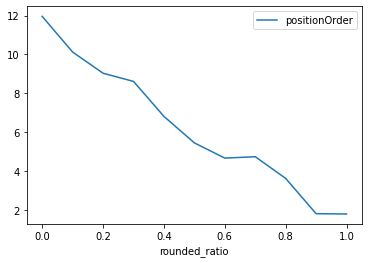

In [157]:
to_plot = dataset[['gp_driver_win_ratio','positionOrder']]
to_plot['rounded_ratio'] = to_plot['gp_driver_win_ratio'].apply(lambda x: np.around(x,1))

to_plot.groupby('rounded_ratio',as_index=False)['positionOrder'].mean().plot.line(x='rounded_ratio',y='positionOrder')

<AxesSubplot:xlabel='position_standings'>

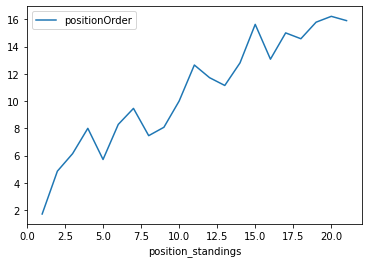

In [159]:
posstand_pos_rel = dataset[dataset.year==2020]\
    .groupby(['position_standings'],as_index=False)['positionOrder'].mean()
posstand_pos_rel.plot.line(x='position_standings',y='positionOrder')

#ploting positionstanding to position 

<AxesSubplot:xlabel='grid'>

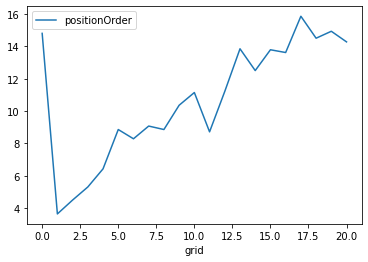

In [190]:
grid_pos_rel = dataset[dataset.year==2020]\
    .groupby(['grid'],as_index=False)['positionOrder'].mean()
grid_pos_rel.plot.line(x='grid',y='positionOrder')

#ploting grid to position 

In [161]:
dataset['grid2'] = dataset['grid'].apply(lambda x: x if x > 0 else 25)

<AxesSubplot:xlabel='driver'>

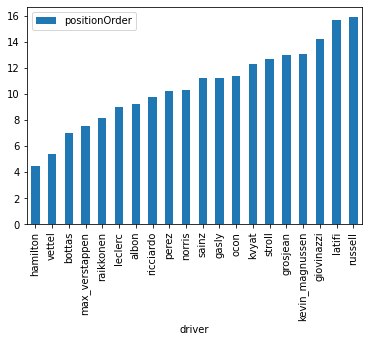

In [196]:
dataset.groupby('driver',as_index=False)\
['positionOrder'].mean()\
.sort_values(by='positionOrder')\
.plot.bar(x='driver',y='positionOrder')

In [199]:
no_finish_driver   =['Accident','Eye injury', 'Fatal accident', 'Driver unwell', 'Injured', 'Injury','Illness']
no_finish_technical=['Alternator', 'Axle', 'Battery', 'Brake duct', 'Brakes',
                    'Broken wing', 'CV joint', 'Chassis', 'Clutch', 'Collision',
                    'Collision damage', 'Crankshaft', 'Damage', 'Debris', 'Differential',
                    'Distributor', 'Driver Seat','Driveshaft', 'Drivetrain', 'ERS', 
                    'Electrical', 'Electronics','Engine', 'Engine fire', 'Engine misfire', 
                    'Excluded', 'Exhaust','Engine misfire', 'Excluded', 'Exhaust',
                    'Power loss', 'Puncture', 'Radiator', 'Rear wing', 'Refuelling',
                    'Retired', 'Safety', 'Safety belt', 'Safety concerns', 'Seat',
                    'Spark plugs', 'Spun off', 'Stalled', 'Steering', 'Supercharger',
                    'Suspension', 'Technical', 'Throttle', 'Track rod', 'Transmission',
                    'Turbo', 'Tyre', 'Tyre puncture', 'Underweight', 'Vibrations',
                    'Water leak', 'Water pipe', 'Water pressure', 'Water pump',
                    'Wheel', 'Wheel bearing', 'Wheel nut', 'Wheel rim', 'Withdrew',
                    'Mechanical', 'Not classified', 'Not restarted', 'Oil leak',
                    'Oil line', 'Oil pipe', 'Oil pressure', 'Oil pump', 'Out of fuel',
                    'Overheating', 'Physical', 'Pneumatics', 'Power Unit','Injection',
                    'Power loss', 'Puncture', 'Radiator', 'Rear wing', 'Refuelling', 
                    'Heat shield fire', 'Hydraulics', 'Ignition', 'Fire', 'Front wing',
                    'Fuel', 'Fuel leak', 'Fuel pipe', 'Fuel pressure', 'Fuel pump',
                    'Fuel rig', 'Fuel system', 'Gearbox', 'Halfshaft', 'Handling',
                    'Driveshaft', 'Drivetrain', 'ERS', 'Electrical', 'Electronics',
                    'Engine', 'Engine fire','Launch control', 'Magneto']
no_finish_bad   = ['+1 Lap', '+10 Laps', '+11 Laps', '+12 Laps', '+13 Laps',
                   '+14 Laps', '+15 Laps', '+16 Laps', '+17 Laps', '+18 Laps',
                   '+19 Laps', '+2 Laps', '+20 Laps', '+21 Laps', '+22 Laps',
                   '+23 Laps', '+24 Laps', '+25 Laps', '+26 Laps', '+29 Laps',
                   '+3 Laps', '+30 Laps', '+38 Laps', '+4 Laps', '+42 Laps',
                   '+44 Laps', '+46 Laps', '+49 Laps', '+5 Laps', '+6 Laps',
                   '+7 Laps', '+8 Laps', '+9 Laps']
no_finish_qualif =['Did not prequalify', 'Did not qualify','Disqualified','107% Rule']

def status_category_reduction(status):
    
    if status in no_finish_driver:
        return 'injury'
    elif status in no_finish_technical:
        return 'technical'
    elif status in no_finish_bad:
        return 'over laped'
    elif status in no_finish_qualif:
        return 'not qualified'
    else:
        return 'finished'
dataset['status'] = dataset['status'].apply(lambda x: status_category_reduction(x))

In [234]:
not_finished=['injury','over laped','not qualified']
def dnf_ratio(driver):
    
    driver_dnf = dataset[dataset.driver == driver]['status']\
        .apply(lambda x: 1 if x in not_finished else 0)
    
    return np.around(driver_dnf.sum()/float(driver_dnf.count()),2)

dataset['dnf_ratio'] = dataset['driver'].apply(lambda x: dnf_ratio(x)).fillna(0)

<AxesSubplot:>

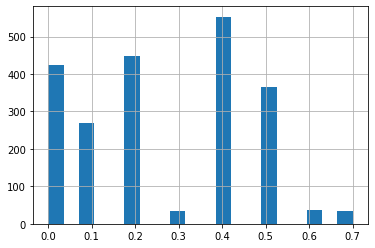

In [204]:
dataset['dnf_ratio'].hist(bins=20)

<AxesSubplot:xlabel='rounded_dnf_ratio'>

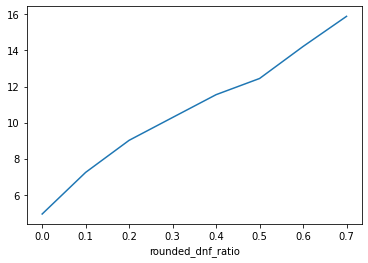

In [205]:

to_plot = dataset[['dnf_ratio','positionOrder']]
to_plot['rounded_dnf_ratio'] = dataset['dnf_ratio'].apply(lambda x: np.around(x,1))
to_plot.groupby('rounded_dnf_ratio')['positionOrder'].mean().plot.line(x='rounded_dnf_ratio',y='positionOrder')

In [393]:
dataset['dnf_ratio'] = 1-dataset['dnf_ratio']

In [482]:
feature_engineered_dataset = dataset[['grid2','position_standings','driver','gp_driver_win_ratio','dnf_ratio','podium']]

In [387]:
# fin
feature_engineered_dataset = dataset[['grid2','name','driver','constructor','position_standings','age','gp_driver_win_ratio','dnf_ratio','podium']]

In [483]:
from sklearn.preprocessing import LabelEncoder

gp_encoder = LabelEncoder()
#feature_engineered_dataset['name'] = gp_encoder.fit_transform(feature_engineered_dataset['name'])

driver_encoder = LabelEncoder()
feature_engineered_dataset['driver'] = driver_encoder.fit_transform(feature_engineered_dataset['driver'])

const_encoder = LabelEncoder()
#feature_engineered_dataset['constructor'] = const_encoder.fit_transform(feature_engineered_dataset['constructor'])


In [484]:
feature_engineered_dataset

,grid2,position_standings,driver,gp_driver_win_ratio,dnf_ratio,podium
2,11,4,5,0.700000,0.99,0
3,2,2,5,0.700000,0.99,1
4,1,3,5,0.700000,0.99,1
25,15,11,13,0.000000,0.63,0
26,4,2,6,0.166667,0.49,1
...,...,...,...,...,...,...
24343,15,20,16,0.000000,0.29,0
24402,2,2,19,0.700000,0.95,0
24406,18,4,14,0.285714,0.81,0
24407,6,7,13,0.333333,0.63,0


In [485]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(feature_engineered_dataset.drop('podium',axis=1),feature_engineered_dataset['podium'])
Y = feature_engineered_dataset['podium']

In [422]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

clf=[
    LogisticRegression(class_weight='balenced'),
    SVC(class_weight='balanced'),
    RandomForestClassifier(class_weight='balanced'),
    DecisionTreeClassifier(random_state=0,class_weight='balanced')
]

In [486]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X,Y,train_size=0.9)

In [487]:
from sklearn.model_selection import KFold,GridSearchCV,cross_val_score,RandomizedSearchCV

In [488]:
for model in clf:
    kf=KFold(n_splits=3)
    scores = cross_val_score(model,train_x,train_y,cv=kf, scoring='f1')
    print(model.__class__.__name__,scores.mean())
    

LogisticRegression 0.7573662880236688
SVC 0.7379143176961432
RandomForestClassifier 0.7292644398583402
DecisionTreeClassifier 0.6825304441930736


In [492]:
logistic_params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': np.linspace(1,10,10),
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight':['balenced',None]
}
logistic = RandomizedSearchCV(clf[0],logistic_params,n_iter=1000,cv=3,verbose=2,random_state=42,n_jobs=-1)
logistic.fit(train_x,train_y)

p=logistic.predict(test_x)

/home/akram/.local/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 400 is smaller than n_iter=1000. Running 400 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1108 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:    2.3s finished


                          | accuracy | precision | recall | f1_score |
RandomizedSearchCV        |    0.894 |     0.795 |  0.674 |    0.729 |


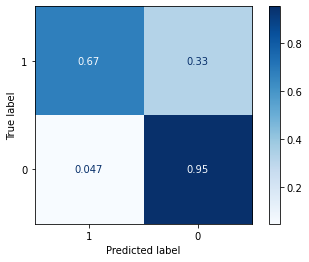

In [493]:
scoring_report(p,test_y,logistic)

In [450]:
logistic.best_params_

{'solver': 'saga', 'penalty': 'l1', 'class_weight': 'balenced', 'C': 2.0}

In [494]:
logistic.best_params_

{'solver': 'newton-cg', 'penalty': 'l2', 'class_weight': 'balenced', 'C': 4.0}

In [ ]:
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'criterion':['gini', 'entropy'],
               'max_features': ['auto', 'sqrt'],
               'max_depth': np.linspace(10, 110, num = 11),
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False],
               'class_weight':['balanced']
}

rand_forest = RandomizedSearchCV(estimator = clf[2], param_distributions = random_grid,
                    n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rand_forest.fit(train_x,train_y)

p=rand_forest.predict(test_x)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min


                          | accuracy | precision | recall | f1_score |
RandomizedSearchCV        |    0.912 |     0.750 |  0.686 |    0.716 |


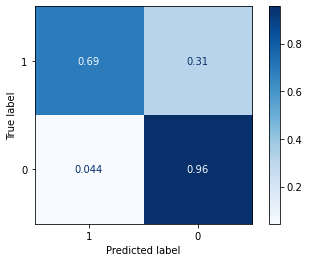

In [452]:
scoring_report(rand_forest.predict(test_x),test_y,rand_forest)

In [453]:
rand_forest.best_params_

{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 40.0,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'bootstrap': True}

In [458]:
parameters = {
    'kernel':('linear', 'rbf','poly'),
    'C': np.linspace(start = 1, stop = 100, num = 20),
    'degree': range(1,5),
    'gamma':['scale', 'auto'],
    'class_weight':['balenced',None]
}

svc = RandomizedSearchCV(clf[1], parameters, n_iter=100, cv=3, random_state=42, verbose=2, n_jobs=-1)
svc.fit(train_x,train_y)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 285 out of 300 | elapsed:    3.5s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:    3.9s finished


RandomizedSearchCV(cv=3, estimator=SVC(class_weight='balanced'), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'C': array([  1.        ,   6.21052632,  11.42105263,  16.63157895,
        21.84210526,  27.05263158,  32.26315789,  37.47368421,
        42.68421053,  47.89473684,  53.10526316,  58.31578947,
        63.52631579,  68.73684211,  73.94736842,  79.15789474,
        84.36842105,  89.57894737,  94.78947368, 100.        ]),
                                        'class_weight': ['balenced', None],
                                        'degree': range(1, 5),
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ('linear', 'rbf', 'poly')},
                   random_state=42, verbose=2)

                          | accuracy | precision | recall | f1_score |
RandomizedSearchCV        |    0.922 |     0.800 |  0.686 |    0.738 |


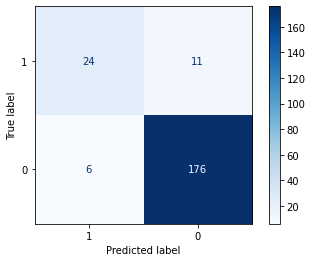

In [461]:
scoring_report(svc.predict(test_x),test_y,svc)

                          | accuracy | precision | recall | f1_score |
RandomizedSearchCV        |    0.839 |     0.600 |  0.812 |    0.690 |


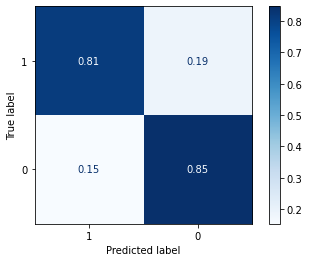

In [358]:
scoring_report(svc.predict(test_x),test_y,svc)

In [383]:
svc.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'degree': 3, 'C': 63.526315789473685}

In [471]:
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,confusion_matrix,plot_confusion_matrix,f1_score
def scoring_report(p,test_y,model):
    
    print('{:25} | {:7} | {:7} | {:6} | {:8} |'.format('','accuracy','precision','recall','f1_score'))
    result = '{:25} | {:8.3f} | {:9.3f} | {:6.3f} | {:8.3f} |'.format(
        model.__class__.__name__,
        accuracy_score(test_y, p),
        precision_score(test_y,p),
        recall_score(test_y, p),
        f1_score(test_y,p)
    )
    print(result)
    plot_confusion_matrix(model, test_x, test_y,labels=[1,0],cmap=plt.cm.Blues,normalize='true')